In [52]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Time    : 2022/9/30 09:23
# @Author  : Wang Yujia
# @File    : GT_fixed_symmetry_gen.ipynb
# @Description : 根据GT_fixed_symmetry_gen_demo.ipynb，计算fixed-price auction的data。ref：信息不对称的paper里symmetry的情况。

# 0. what for
1. 在`GT_fixed_symmetry_gen_demo.ipynb`上实验过的思路，现在一次性输入所有的auction settings，得到相应的输出
2. **Steps**：
    - collect GT计算需要的features: `features_GT`，NN需要的features：`unique_setting`
        - features_GT = ['bidfee','retail','finalprice']
        - unique_setting = ['product_id', 'bidincrement', 'bidfee','retail','finalprice'] *[Unsure for now]*
        - Note：对于GT来说可能会出现不同的商品对应同样的retail，需要把他们当做不同的商品处理。GT并不在意是什么商品，只是在意`retail`大小
    - 根据`features_GT`计算GT预测的结果`n`和`p`

# 1. Preparations
## 1.1 全局设置

In [9]:

data_selected_path = "../../data/info_asymm/datawithnp_fixed_symmetry_selected.csv"
# data_key_path
data_key_path = "../../data/info_asymm/data_key_GT_1_fixed.csv"

# output path
data_path_root = "../../data/info_asymm/results/fixed_symmetry/"
# target data is from method-2
filename_head = "GT_fixed_symmetry_P2_K="
filename_tail = ".csv"

# GT计算需要的features
features_GT = ['bidincrement','bidfee','retail']

import numpy as np
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator # 用于设置刻度间隔
from visdom import Visdom
from tqdm import tqdm

## 1.2 读取data

In [4]:
data = pd.read_csv(data_selected_path, encoding="utf-8")

data_key = data[features_GT].copy()
data_key.drop_duplicates(inplace=True,ignore_index=True)
data_key.to_csv(data_key_path,header=True, encoding="utf-8",index=False)

print("For symmetry GT model in constant-price auctions, there are *{}* settings waiting to be inferred.".format(data_key.shape[0]))

For symmetry GT model in constant-price auctions, there are *22* settings waiting to be inferred.


## 1.3 functions about 'key'

In [5]:
# get key from i in 'data_key'
def get_key_from_index(i,flag="NotStr"):
    if(flag == "str"):
        key_i = list(data_key.iloc[i,:])
        key_i_str = (str(key_i[0]),str(key_i[1]),str(key_i[2]))
        return key_i_str
    else:
        key_i = data_key.iloc[i,:]
        return key_i

#features_GT = ['bidincrement','bidfee','retail']
def select_data_fromkey(key_i_str):
    return data[(data['bidincrement'] == key_i_str[0]) & (data['bidfee'] == key_i_str[1]) & (data['retail'] == key_i_str[2])].copy()

# 2. U&P
1. For fixed-price, there is $Q = inf $
2. `U[key][0]`初始化为1，方便后续`P`的计算
3. `U[key][j]`表示在某一个setting下：
> The probability that somebody makes the jth bid (given that j − 1 previous bids have been made)
4. `P`作为一个**dict**，它的key是`features_GT`,每一个key对应一个大小为(T+1)的list.
5. 由于threshold的存在，`P[key_i]`的大小设置为`K+1`，其中`p[key_i][K]`记录的是sum(P[i]) when i > K
    - 如果threshold> T_i，则用0padding

In [7]:
# whether set threshold or not
threshold_flag = 1
plot_flag = 0

K = 300
col_names = ['bidincrement','bidfee','retail']
tmp = np.arange(0,K)
tmp_str = [str(x) for x in tmp]
col_names.extend(tmp_str)

P = pd.DataFrame(columns=col_names)

if(plot_flag):
    env_str = 'P_GT-1_threshold'
    viz = Visdom(env=env_str)
print("Done")

Done


6. 想对比归一化的区别：可以把第一个elif的条件改了
7. **`P[i]`表示`duration=i+1`的概率，i从0开始计数**

In [10]:
######################################################### new
# for every uniq setting i
cnt = 0
for i in tqdm(range(0,data_key.shape[0])):
# for i in tqdm(range(8,10)):

    # get i_th data_key
    key_i = get_key_from_index(i)
    # print(key_i)
    data_i = select_data_fromkey(key_i)
    data_i.reset_index(drop=True,inplace=True)

    # Get params
    v = float(data_i['retail'].unique())            # retail price = valuation
    d = float(data_i['bidincrement'].unique())      # bid increment
    b = float(data_i['bidfee'].unique())            # bid fee
    T_i = int((v-b)/d)                              # duration limitation

    # key_i_str = get_key_from_index(i,"str")         # key for P

    # solve for U
    U = [0] * (T_i + 1)                               # the prob. that someone offers a bid in t_th round
    U[0] = 1
    for t in range(1,len(U)):
        U[t] = 1.0-(b/(v-d*(t-1)))
        assert U[t]>=0, "U[t]<0 when t ={},and b = {},v = {}, d = {}".format(t,b,v,d)

    # decide whether set threshold or not
    if (threshold_flag != 1):
        K = T_i

    # solve for P
    p = np.array([0.0]*(K))
    tmp = np.array([0.0]*(K+3))                         # tmp的大小不需要太精确
    tmp[0] = 1.0

    # solve for P
    if((K+1) > T_i):                                    # threshold>T_i时，补零
        cnt += 1
        for t in range(0,T_i):
            tmp[t+1] = tmp[t]*U[t]                      # tmp[t]存了到(t-1)的连乘积
            p[t] = (1-U[t+1])*tmp[t+1]
            print(p[t])
        assert np.min(p) >= 0, "A: in {}, p<0, when b = {},v = {}, d = {}".format(i,b,v,d)

    elif((K+1) == T_i):                                 # threshold==T_i时
        for t in range(0,K):
            tmp[t+1] = tmp[t]*U[t]                      # tmp[t]存了到(t-1)的连乘积
            p[t] = (1-U[t+1])*tmp[t+1]
        p[K-1] = 1-sum(p)
        assert np.min(p) >= 0, "B: in {}, p<0, when b = {},v = {}, d = {}".format(i,b,v,d)

    elif((K+1) < T_i):                              # threshold<T_i时，归一化
        for t in range(0,K):
            tmp[t+1] = tmp[t]*U[t]                      # tmp[t]存了到(t-1)的连乘积
            p[t] = (1-U[t+1])*tmp[t+1]
        assert np.min(p) >= 0, "C: in {}, p<0, when b = {},v = {}, d = {}".format(i,b,v,d)

        # 归一化
        scale_sum = np.sum(p)
        p = p/scale_sum

    else:
        print("Undecided yet. Waiting to be completed.")

    # concat df P
    pd_tmp = pd.DataFrame(data=[[d,b,v]])
    pd_tmp = pd.concat([pd_tmp,pd.DataFrame(p).T],axis=1)
    pd_tmp.columns = col_names
    P = pd.concat([P,pd_tmp],ignore_index=True)
    # draw

    if(plot_flag& (i%10 == 0)):
        viz.line(p,np.arange(0,p.shape[0]),win = 'P_'+str(i),env=env_str, opts= dict(title = f'P_{i}_v={v}_b={b}_d={d}'))

print("Done")
print(cnt)

100%|██████████| 22/22 [00:00<00:00, 453.61it/s]

Done
0


# 3. Output ans save
1. 每个unique setting对应着一组keys + 一个distrb

In [11]:
filename_P = data_path_root + filename_head + str(K) + filename_tail
col_names = ['bidincrement','bidfee','retail','P']

In [12]:
# 保存整个环境
if(plot_flag):
    viz.save(envs=[env_str])
P.to_csv(filename_P,header=True,index=False,encoding="utf-8")
print(filename_P)
print("DONE")

../../data/info_asymm/results/fixed_symmetry/GT_fixed_symmetry_P2_K=300.csv
DONE


# 4. Test and Plot
## 4.1 plot
1. 根据指定的index进行画图，

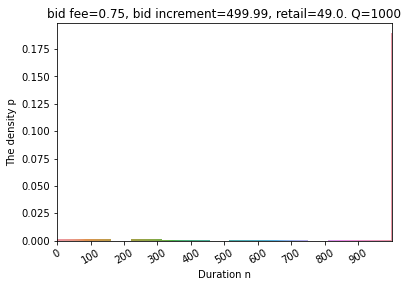

Plot is DONE


In [61]:
index_i = 28
key_i_forplot =  get_key_from_index(index_i)

plt.xlabel("Duration n")
plt.ylabel("The density p")
plt.title("bid increment={0}, bid fee={1}, retail={2}, Q={3}, K={4}".format(float(key_i_forplot[0])*0.01,float(key_i_forplot[1]),key_i_forplot[2],Q[key_i_forplot],K))

ax = sns.barplot(x = np.arange(0,len(P[key_i_forplot])),y=P[key_i_forplot])

# 设置刻度
steps_xaxis = np.arange(0, Q[index_i], step=steps_xaxis)
plt.xticks(steps_xaxis,steps_xaxis,rotation=30)

plt.show()
print("Plot is DONE")